## Import Necessary Libraries

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import zscore
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
from sklearn.linear_model import LinearRegression
warnings.filterwarnings('ignore')
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV

### Dataset Reading

In [2]:
traffic_df = pd.read_csv("Dataset_Uber Traffic - Dataset_Uber Traffic.csv")
traffic_df.head()

,DateTime,Junction,Vehicles,ID
0,01/11/15 0:00,1,15,20151101001
1,01/11/15 1:00,1,13,20151101011
2,01/11/15 2:00,1,10,20151101021
3,01/11/15 3:00,1,7,20151101031
4,01/11/15 4:00,1,9,20151101041


## Check NULL Values

In [3]:
traffic_df.isna().sum()

DateTime    0
Junction    0
Vehicles    0
ID          0
dtype: int64

### Check DataTypes

In [4]:
traffic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48120 entries, 0 to 48119
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   DateTime  48120 non-null  object
 1   Junction  48120 non-null  int64 
 2   Vehicles  48120 non-null  int64 
 3   ID        48120 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 1.5+ MB


## Drop Duplicates

In [5]:
print('before ',traffic_df.shape[0])
traffic_df.drop_duplicates(keep="first", inplace=True) 
print('after ',traffic_df.shape[0])

before  48120
after  48120


### Statistical Analysis

In [6]:
display(traffic_df.describe())
display(traffic_df.describe(include = 'object'))

,Junction,Vehicles,ID
count,48120.000000,48120.000000,4.812000e+04
mean,2.180549,22.791334,2.016330e+10
std,0.966955,20.750063,5.944854e+06
min,1.000000,1.000000,2.015110e+10
25%,1.000000,9.000000,2.016042e+10
50%,2.000000,15.000000,2.016093e+10
75%,3.000000,29.000000,2.017023e+10
max,4.000000,180.000000,2.017063e+10


,DateTime
count,48120
unique,14592
top,30/06/17 23:00
freq,4


#### Create new time-based features

In [7]:
# Convert DateTime column to datetime format with dayfirst=True for consistency
traffic_df['DateTime'] = pd.to_datetime(traffic_df['DateTime'], format='%d/%m/%y %H:%M', errors='coerce')

# Drop rows where DateTime could not be converted (if necessary)
traffic_df = traffic_df.dropna(subset=['DateTime'])

# Create new time-based features
traffic_df['hour'] = traffic_df['DateTime'].dt.hour               # Extract the hour
traffic_df['day_of_week'] = traffic_df['DateTime'].dt.dayofweek   # Extract the day of the week (0 = Monday, 6 = Sunday)
traffic_df['month'] = traffic_df['DateTime'].dt.month             # Extract the month

# Verify the new features
display(traffic_df.head())

,DateTime,Junction,Vehicles,ID,hour,day_of_week,month
0,2015-11-01 00:00:00,1,15,20151101001,0,6,11
1,2015-11-01 01:00:00,1,13,20151101011,1,6,11
2,2015-11-01 02:00:00,1,10,20151101021,2,6,11
3,2015-11-01 03:00:00,1,7,20151101031,3,6,11
4,2015-11-01 04:00:00,1,9,20151101041,4,6,11


In [8]:
traffic_df['Vehicles'].unique()

array([ 15,  13,  10,   7,   9,   6,   8,  11,  12,  17,  16,  20,  19,
        14,  22,  32,  31,  35,  26,  34,  30,  27,  24,  29,  21,  18,
        33,  28,  25,  23,  40,  38,  36,  48,  43,  41,  37,  39,  42,
        44,  47,  50,  45,  46,  70,  54,  52,  55,  49,  58,  64,  62,
        51,  53,  61,  56,  57,  63,  59,  60,  67,  76,  79,  66,  65,
        68,  69,  86,  73,  77,  74,  71,  72,  78,   5,  81,  75,  80,
        82,  89,  83,  93,  91,  85,  90,  84,  87,  94,  92, 106,  98,
        88,  96, 120,  97, 104,  95, 100, 112, 103, 105, 143, 134, 135,
       141, 156, 110, 102,  99, 132, 124, 113, 109, 115, 101, 108, 114,
       107, 111, 136, 129, 118, 116, 123, 133, 128, 117, 121, 127, 140,
       126, 122, 119,   2,   4,   3,   1, 125, 180, 173, 162], dtype=int64)

In [9]:
# Example: 1-hour and 24-hour lag features
traffic_df['lag_1'] = traffic_df['Vehicles'].shift(1)  # Traffic from the previous hour
traffic_df['lag_24'] = traffic_df['Vehicles'].shift(24)  # Traffic from the same hour on the previous day

### Correlation matrix to assess feature relevance

In [10]:
traffic_df[['Vehicles', 'lag_1', 'lag_24']].head(5)

,Vehicles,lag_1,lag_24
0,15,NaN,NaN
1,13,15.0,NaN
2,10,13.0,NaN
3,7,10.0,NaN
4,9,7.0,NaN


In [11]:
correlation_matrix = traffic_df.corr()
correlation_matrix['Vehicles'].sort_values(ascending=False)

Vehicles       1.000000
lag_1          0.969982
lag_24         0.901522
DateTime       0.266244
ID             0.227974
hour           0.219938
month         -0.022723
day_of_week   -0.126027
Junction      -0.613787
Name: Vehicles, dtype: float64

In [12]:
pip install holidays

Note: you may need to restart the kernel to use updated packages.


In [13]:
import holidays

# Binary indicator for weekends
traffic_df['is_weekend'] = traffic_df['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

# Optionally, add special events if dates are known (example uses U.S. holidays)
us_holidays = holidays.US()
traffic_df['is_holiday'] = traffic_df['DateTime'].apply(lambda x: 1 if x in us_holidays else 0)

In [14]:
# Prepare data (drop rows with NaNs created by lag features)
traffic_df = traffic_df.dropna()

# Define target and features
X = traffic_df[['hour', 'day_of_week', 'month', 'lag_1', 'lag_24', 'is_weekend', 'is_holiday']]
y = traffic_df['Vehicles']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest model to assess feature importance
model = RandomForestRegressor()
model.fit(X_train, y_train)

# Get feature importances
feature_importances = model.feature_importances_

# Display feature importance
for feature, importance in zip(X.columns, feature_importances):
    print(f'{feature}: {importance}')


hour: 0.018304490026666703
day_of_week: 0.00682588047964803
month: 0.008359649142880435
lag_1: 0.9438346059621872
lag_24: 0.0210667921361699
is_weekend: 0.0012616467526471126
is_holiday: 0.00034693549980074635


In [15]:
# Select important features based on feature importance
features = ['lag_1', 'lag_24', 'hour']
X = traffic_df[features]
y = traffic_df['Vehicles']

# Split the data into train and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Using Ensemble model

In [16]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Train the model
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'R-squared (R2): {r2}')

Mean Absolute Error (MAE): 2.8539478935785603
Mean Squared Error (MSE): 18.8353900691945
R-squared (R2): 0.9549217137167868


In [17]:
traffic_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 48096 entries, 24 to 48119
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   DateTime     48096 non-null  datetime64[ns]
 1   Junction     48096 non-null  int64         
 2   Vehicles     48096 non-null  int64         
 3   ID           48096 non-null  int64         
 4   hour         48096 non-null  int32         
 5   day_of_week  48096 non-null  int32         
 6   month        48096 non-null  int32         
 7   lag_1        48096 non-null  float64       
 8   lag_24       48096 non-null  float64       
 9   is_weekend   48096 non-null  int64         
 10  is_holiday   48096 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int32(3), int64(5)
memory usage: 3.9 MB


### Read whather data

In [18]:
we_data = pd.read_csv("weatherHistory.csv")
we_data.head()

,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary
0,2006-04-01 00:00:00.000 +0200,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.
1,2006-04-01 01:00:00.000 +0200,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.
2,2006-04-01 02:00:00.000 +0200,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,Partly cloudy throughout the day.
3,2006-04-01 03:00:00.000 +0200,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,0.0,1016.41,Partly cloudy throughout the day.
4,2006-04-01 04:00:00.000 +0200,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,0.0,1016.51,Partly cloudy throughout the day.


In [19]:
we_data.shape

(96453, 12)

In [20]:
we_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96453 entries, 0 to 96452
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Formatted Date            96453 non-null  object 
 1   Summary                   96453 non-null  object 
 2   Precip Type               95936 non-null  object 
 3   Temperature (C)           96453 non-null  float64
 4   Apparent Temperature (C)  96453 non-null  float64
 5   Humidity                  96453 non-null  float64
 6   Wind Speed (km/h)         96453 non-null  float64
 7   Wind Bearing (degrees)    96453 non-null  float64
 8   Visibility (km)           96453 non-null  float64
 9   Loud Cover                96453 non-null  float64
 10  Pressure (millibars)      96453 non-null  float64
 11  Daily Summary             96453 non-null  object 
dtypes: float64(8), object(4)
memory usage: 8.8+ MB


In [21]:
we_data['Formatted Date'] = pd.to_datetime(we_data['Formatted Date'], errors='coerce')

# Check if there are any NaT values (rows where conversion failed)
print(we_data['Formatted Date'].isna().sum())

0


In [22]:
we_data.tail()

,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary
96448,2016-09-09 19:00:00+02:00,Partly Cloudy,rain,26.016667,26.016667,0.43,10.9963,31.0,16.1000,0.0,1014.36,Partly cloudy starting in the morning.
96449,2016-09-09 20:00:00+02:00,Partly Cloudy,rain,24.583333,24.583333,0.48,10.0947,20.0,15.5526,0.0,1015.16,Partly cloudy starting in the morning.
96450,2016-09-09 21:00:00+02:00,Partly Cloudy,rain,22.038889,22.038889,0.56,8.9838,30.0,16.1000,0.0,1015.66,Partly cloudy starting in the morning.
96451,2016-09-09 22:00:00+02:00,Partly Cloudy,rain,21.522222,21.522222,0.60,10.5294,20.0,16.1000,0.0,1015.95,Partly cloudy starting in the morning.
96452,2016-09-09 23:00:00+02:00,Partly Cloudy,rain,20.438889,20.438889,0.61,5.8765,39.0,15.5204,0.0,1016.16,Partly cloudy starting in the morning.


In [23]:
# Convert both columns to datetime if not already
traffic_df['DateTime'] = pd.to_datetime(traffic_df['DateTime'], format='%d/%m/%y %H:%M', errors='coerce')
we_data['Formatted Date'] = pd.to_datetime(we_data['Formatted Date'], errors='coerce')

# Localize the naive column to 'UTC' (or your desired timezone)
if traffic_df['DateTime'].dt.tz is None:  # Check if traffic_df['DateTime'] is naive
    traffic_df['DateTime'] = traffic_df['DateTime'].dt.tz_localize('UTC')
if we_data['Formatted Date'].dt.tz is None:  # Check if we_data['Formatted Date'] is naive
    we_data['Formatted Date'] = we_data['Formatted Date'].dt.tz_localize('UTC')

# Now convert both to the same timezone (e.g., 'UTC+02:00')
traffic_df['DateTime'] = traffic_df['DateTime'].dt.tz_convert('UTC+02:00')
we_data['Formatted Date'] = we_data['Formatted Date'].dt.tz_convert('UTC+02:00')

# Merge the dataframes on the datetime columns
merged_df = pd.merge(traffic_df, we_data, left_on='DateTime', right_on='Formatted Date', how='inner')
merged_df.head()


,DateTime,Junction,Vehicles,ID,hour,day_of_week,month,lag_1,lag_24,is_weekend,...,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary
0,2016-03-27 03:00:00+02:00,1,19,20160327011,1,6,3,24.0,24.0,1,...,rain,4.950000,2.444444,0.89,10.8192,341.0,11.8496,0.0,1016.67,Mostly cloudy throughout the day.
1,2016-03-27 03:00:00+02:00,2,10,20160327012,1,6,3,8.0,10.0,1,...,rain,4.950000,2.444444,0.89,10.8192,341.0,11.8496,0.0,1016.67,Mostly cloudy throughout the day.
2,2016-03-27 03:00:00+02:00,3,4,20160327013,1,6,3,6.0,6.0,1,...,rain,4.950000,2.444444,0.89,10.8192,341.0,11.8496,0.0,1016.67,Mostly cloudy throughout the day.
3,2016-03-27 04:00:00+02:00,1,17,20160327021,2,6,3,19.0,18.0,1,...,rain,5.488889,2.522222,0.93,13.9909,350.0,7.9695,0.0,1016.41,Mostly cloudy throughout the day.
4,2016-03-27 04:00:00+02:00,2,9,20160327022,2,6,3,10.0,8.0,1,...,rain,5.488889,2.522222,0.93,13.9909,350.0,7.9695,0.0,1016.41,Mostly cloudy throughout the day.


In [24]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15624 entries, 0 to 15623
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype                    
---  ------                    --------------  -----                    
 0   DateTime                  15624 non-null  datetime64[ns, UTC+02:00]
 1   Junction                  15624 non-null  int64                    
 2   Vehicles                  15624 non-null  int64                    
 3   ID                        15624 non-null  int64                    
 4   hour                      15624 non-null  int32                    
 5   day_of_week               15624 non-null  int32                    
 6   month                     15624 non-null  int32                    
 7   lag_1                     15624 non-null  float64                  
 8   lag_24                    15624 non-null  float64                  
 9   is_weekend                15624 non-null  int64                    
 10  is_holiday

In [25]:
merged_df.shape

(15624, 23)

### Consistency of Data Reporting¶

In [26]:
# Check the number of records per junction
records_per_junction = traffic_df['Junction'].value_counts()

# Check for irregular time intervals
time_diffs = traffic_df.groupby('Junction').apply(lambda x: x['DateTime'].diff().unique())

### Analyze Time Range for Each Junction

In [27]:
time_range_per_junction = traffic_df.groupby('Junction')['DateTime'].agg(['min', 'max'])
time_range_per_junction

,min,max
Junction,,
1,2015-11-02 02:00:00+02:00,2017-07-01 01:00:00+02:00
2,2015-11-01 02:00:00+02:00,2017-07-01 01:00:00+02:00
3,2015-11-01 02:00:00+02:00,2017-07-01 01:00:00+02:00
4,2017-01-01 02:00:00+02:00,2017-07-01 01:00:00+02:00


### Check for Missing Data¶

In [28]:
traffic_df['DateTime'] = pd.to_datetime(traffic_df['DateTime'], format='%d/%m/%y %H:%M', errors='coerce')
traffic_df = traffic_df.sort_values(by='DateTime')

# Check for missing timestamps
expected_timestamps = pd.date_range(start=traffic_df['DateTime'].min(), 
                                    end=traffic_df['DateTime'].max(), 
                                    freq='H')
missing_timestamps = expected_timestamps.difference(traffic_df['DateTime'])

### Outlier Detection

Missing Timestamps:
DatetimeIndex([], dtype='datetime64[ns, UTC+02:00]', freq=None)

Records per Junction:
Junction
2    14592
3    14592
1    14568
4     4344
Name: count, dtype: int64

Time Intervals:
Junction
1    [NaT, 0 days 01:00:00]
2    [NaT, 0 days 01:00:00]
3    [NaT, 0 days 01:00:00]
4    [NaT, 0 days 01:00:00]
dtype: object

Time Range for Each Junction:
                               min                       max
Junction                                                    
1        2015-11-02 02:00:00+02:00 2017-07-01 01:00:00+02:00
2        2015-11-01 02:00:00+02:00 2017-07-01 01:00:00+02:00
3        2015-11-01 02:00:00+02:00 2017-07-01 01:00:00+02:00
4        2017-01-01 02:00:00+02:00 2017-07-01 01:00:00+02:00

Outliers in Vehicle Counts:
                       DateTime  Junction  Vehicles           ID  hour  \
31531 2016-02-06 21:00:00+02:00         3        71  20160206193    19   
2603  2016-02-17 13:00:00+02:00         1        70  20160217111    11   
2890  2016-02-

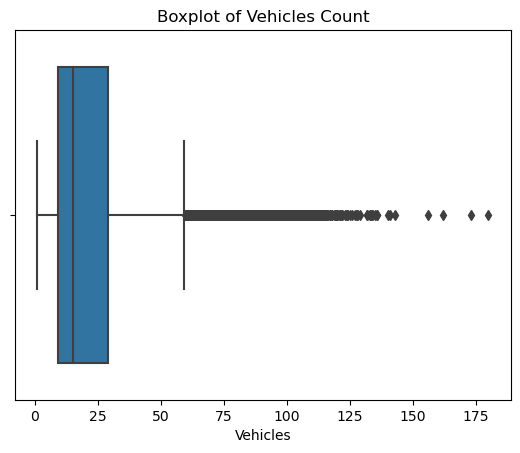

In [29]:
# Detecting outliers in 'Vehicles' column
Q1 = traffic_df['Vehicles'].quantile(0.25)
Q3 = traffic_df['Vehicles'].quantile(0.75)
IQR = Q3 - Q1
outliers = traffic_df[(traffic_df['Vehicles'] < (Q1 - 1.5 * IQR)) | (traffic_df['Vehicles'] > (Q3 + 1.5 * IQR))]
# Step 1: Print Missing Timestamps
print("Missing Timestamps:")
print(missing_timestamps)

# Step 2: Print Records Per Junction and Time Intervals
print("\nRecords per Junction:")
print(records_per_junction)
print("\nTime Intervals:")
print(time_diffs)

# Step 3: Print Time Range for Each Junction
print("\nTime Range for Each Junction:")
print(time_range_per_junction)

# Step 4: Print and Visualize Outliers
print("\nOutliers in Vehicle Counts:")
print(outliers)

# Visualizing Outliers with a Boxplot
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(x=traffic_df['Vehicles'])
plt.title('Boxplot of Vehicles Count')
plt.show()

In [30]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

# Read the traffic data
traffic_df = pd.read_csv("Dataset_Uber Traffic - Dataset_Uber Traffic.csv")

# Feature Engineering
traffic_df['DateTime'] = pd.to_datetime(traffic_df['DateTime'], format='%d/%m/%y %H:%M', errors='coerce')
traffic_df['HourOfDay'] = traffic_df['DateTime'].dt.hour
traffic_df['DayOfWeek'] = traffic_df['DateTime'].dt.dayofweek

# Encode categorical variable 'Junction'
traffic_df = pd.get_dummies(traffic_df, columns=['Junction'], drop_first=True)

# Define features and target
features = ['HourOfDay', 'DayOfWeek', 'Junction_2', 'Junction_3', 'Junction_4']
target = 'Vehicles'

# Split the data into training and testing sets
train_data, test_data = train_test_split(traffic_df, test_size=0.2, random_state=42)

# Model Training
model = LinearRegression()
model.fit(train_data[features], train_data[target])

# Model Prediction
predictions = model.predict(test_data[features])

# Model Evaluation
mae = mean_absolute_error(test_data[target], predictions)
print(f'Mean Absolute Error: {mae}')


Mean Absolute Error: 9.07005603205783


In [31]:
# traffic_df['Vehicles'].unique()

In [32]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Assume 'traffic_df' is your DataFrame

# Define features and target
features = ['HourOfDay', 'DayOfWeek', 'Junction_2', 'Junction_3', 'Junction_4']
target = 'Vehicles'

# Set a threshold to classify as high or low traffic
threshold = 10  # You can adjust this threshold based on your problem

# Create a binary target variable
traffic_df['TrafficLevel'] = (traffic_df[target] > threshold).astype(int)

# Split the data into training and testing sets
train_data, test_data = train_test_split(traffic_df, test_size=0.3, random_state=42)

# Separate features and target in the training and testing sets
X_train, y_train = train_data[features], train_data['TrafficLevel']
X_test, y_test = test_data[features], test_data['TrafficLevel']

# Train a random forest classifier
classifier = RandomForestClassifier(random_state=42)
classifier.fit(X_train, y_train)

# Make predictions on the test set
predictions = classifier.predict(X_test)

# Evaluate the classifier
accuracy = accuracy_score(y_test, predictions)
classification_report_str = classification_report(y_test, predictions)

# Print the metrics
print(f'Accuracy: {accuracy:.2%}')
print('Classification Report:')
print(classification_report_str)

Accuracy: 82.98%
Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.70      0.73      4664
           1       0.86      0.89      0.88      9772

    accuracy                           0.83     14436
   macro avg       0.81      0.80      0.80     14436
weighted avg       0.83      0.83      0.83     14436



In [33]:
import pandas as pd
from datetime import datetime
from sklearn.ensemble import RandomForestClassifier

# Assume 'classifier' is your trained RandomForestClassifier
# Assume 'features' is a list of feature names used in training the model

def predict_traffic_level(input_date, hour_of_day, junction):
    # Convert input_date to a datetime object
    input_datetime = datetime.strptime(input_date, '%Y-%m-%d %H:%M:%S')
    
    # Determine the day of the week (Monday is 0, Sunday is 6)
    day_of_week = input_datetime.weekday()
    
    # Create a DataFrame with the input values
    input_data = pd.DataFrame({
        'HourOfDay': [hour_of_day],
        'DayOfWeek': [day_of_week],
        'Junction_2': [1 if junction == 2 else 0],
        'Junction_3': [1 if junction == 3 else 0],
        'Junction_4': [1 if junction == 4 else 0]
    })
    
    # Make a prediction using the trained classifier
    traffic_level = classifier.predict(input_data[features])[0]
    
    # Interpret the predicted traffic level
    if traffic_level == 0:
        return 'Low Traffic'
    elif traffic_level == 1:
        return 'High Traffic'
    else:
        return 'Unknown'

# Example usage
input_date = '2023-01-01 14:00:00'
hour = 14  # Example hour of the day
junction = 1  # Example junction

predicted_traffic_level = predict_traffic_level(input_date, hour, junction)
print(f'Predicted Traffic Level: {predicted_traffic_level}')

Predicted Traffic Level: High Traffic


In [34]:
input_date = '2023-01-01 14:00:00'
hour = 14  # Example hour of the day
junction = 2  # Example junction

predicted_traffic_level = predict_traffic_level(input_date, hour, junction)
print(f'Predicted Traffic Level: {predicted_traffic_level}')


Predicted Traffic Level: Low Traffic


In [35]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Assume 'traffic_df' is your DataFrame

# Define features and target
features = ['HourOfDay', 'DayOfWeek', 'Junction_2', 'Junction_3', 'Junction_4']
target = 'Vehicles'

# Set a threshold to classify as high or low traffic
threshold = 10  # You can adjust this threshold based on your problem

# Create a binary target variable
traffic_df['TrafficLevel'] = (traffic_df[target] > threshold).astype(int)

# Split the data into training and testing sets
train_data, test_data = train_test_split(traffic_df, test_size=0.3, random_state=42)

# Separate features and target in the training and testing sets
X_train, y_train = train_data[features], train_data['TrafficLevel']
X_test, y_test = test_data[features], test_data['TrafficLevel']

# Train a Decision Tree classifier
dt_classifier = DecisionTreeClassifier(random_state=42)
dt_classifier.fit(X_train, y_train)
dt_predictions = dt_classifier.predict(X_test)
dt_accuracy = accuracy_score(y_test, dt_predictions)
dt_classification_report = classification_report(y_test, dt_predictions)

# Train a Random Forest classifier
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train, y_train)
rf_predictions = rf_classifier.predict(X_test)
rf_accuracy = accuracy_score(y_test, rf_predictions)
rf_classification_report = classification_report(y_test, rf_predictions)

# Train a Support Vector Machine (SVM) classifier
svm_classifier = SVC(random_state=42)
svm_classifier.fit(X_train, y_train)
svm_predictions = svm_classifier.predict(X_test)
svm_accuracy = accuracy_score(y_test, svm_predictions)
svm_classification_report = classification_report(y_test, svm_predictions)

# Train a k-Nearest Neighbors (KNN) classifier
knn_classifier = KNeighborsClassifier()
knn_classifier.fit(X_train, y_train)
knn_predictions = knn_classifier.predict(X_test)
knn_accuracy = accuracy_score(y_test, knn_predictions)
knn_classification_report = classification_report(y_test, knn_predictions)

# Train a Logistic Regression classifier
lr_classifier = LogisticRegression(random_state=42)
lr_classifier.fit(X_train, y_train)
lr_predictions = lr_classifier.predict(X_test)
lr_accuracy = accuracy_score(y_test, lr_predictions)
lr_classification_report = classification_report(y_test, lr_predictions)

# Train a Gradient Boosting classifier
gb_classifier = GradientBoostingClassifier(random_state=42)
gb_classifier.fit(X_train, y_train)
gb_predictions = gb_classifier.predict(X_test)
gb_accuracy = accuracy_score(y_test, gb_predictions)
gb_classification_report = classification_report(y_test, gb_predictions)

# Print the metrics for each classifier
print('Decision Tree Classifier:')
print(f'Accuracy: {dt_accuracy:.2%}')
print('Classification Report:')
print(dt_classification_report)

print('\nRandom Forest Classifier:')
print(f'Accuracy: {rf_accuracy:.2%}')
print('Classification Report:')
print(rf_classification_report)

print('\nSupport Vector Machine (SVM) Classifier:')
print(f'Accuracy: {svm_accuracy:.2%}')
print('Classification Report:')
print(svm_classification_report)

print('\nk-Nearest Neighbors (KNN) Classifier:')
print(f'Accuracy: {knn_accuracy:.2%}')
print('Classification Report:')
print(knn_classification_report)

print('\nLogistic Regression Classifier:')
print(f'Accuracy: {lr_accuracy:.2%}')
print('Classification Report:')
print(lr_classification_report)

print('\nGradient Boosting Classifier:')
print(f'Accuracy: {gb_accuracy:.2%}')
print('Classification Report:')
print(gb_classification_report)

Decision Tree Classifier:
Accuracy: 82.94%
Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.71      0.73      4664
           1       0.86      0.89      0.88      9772

    accuracy                           0.83     14436
   macro avg       0.81      0.80      0.80     14436
weighted avg       0.83      0.83      0.83     14436


Random Forest Classifier:
Accuracy: 82.98%
Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.70      0.73      4664
           1       0.86      0.89      0.88      9772

    accuracy                           0.83     14436
   macro avg       0.81      0.80      0.80     14436
weighted avg       0.83      0.83      0.83     14436


Support Vector Machine (SVM) Classifier:
Accuracy: 82.14%
Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.67      0.71      4664
           1       0.8

In [36]:
pip install xgboost-cpu

Note: you may need to restart the kernel to use updated packages.


In [37]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import xgboost as xgb

# Step 1: Feature Engineering
# Assuming 'traffic_df' has columns 'DateTime', 'Junction', 'Vehicles'

# Convert 'DateTime' to datetime if not already done
# Extract time-based features
traffic_df['HourOfDay'] = traffic_df['DateTime'].dt.hour
traffic_df['DayOfWeek'] = traffic_df['DateTime'].dt.dayofweek
traffic_df['Month'] = traffic_df['DateTime'].dt.month

# One-hot encode 'Junction' (if it's categorical)
traffic_df = pd.get_dummies(traffic_df, columns=['Junction_2'], prefix='Junction', drop_first=True)

# Drop unnecessary columns
features = ['HourOfDay', 'DayOfWeek', 'Month'] + [col for col in traffic_df.columns if col.startswith('Junction_')]
target = 'Vehicles'

# Step 2: Train-test split
X = traffic_df[features]
y = traffic_df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Step 3: Model Training and Evaluation
# Baseline Models
def evaluate_model(model, X_train, X_test, y_train, y_test):
    # Fit the model
    model.fit(X_train, y_train)
    # Predict
    y_pred = model.predict(X_test)
    # Metrics
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return mae, mse, r2

# Initialize models
models = {
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "XGBoost": xgb.XGBRegressor(random_state=42)
}

print("Baseline Model Results:")
for name, model in models.items():
    mae, mse, r2 = evaluate_model(model, X_train, X_test, y_train, y_test)
    print(f"{name}:\n  MAE: {mae:.2f}, MSE: {mse:.2f}, R²: {r2:.2f}\n")

# Step 4: Hyperparameter Tuning
# Example: Tuning Random Forest
rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10]
}
rf_grid = GridSearchCV(RandomForestRegressor(random_state=42), rf_param_grid, scoring='r2', cv=3, n_jobs=-1)
rf_grid.fit(X_train, y_train)

# Get the best model
best_rf = rf_grid.best_estimator_
print(f"Best Random Forest Parameters: {rf_grid.best_params_}")

# Evaluate the tuned model
mae_rf, mse_rf, r2_rf = evaluate_model(best_rf, X_train, X_test, y_train, y_test)
print(f"Tuned Random Forest:\n  MAE: {mae_rf:.2f}, MSE: {mse_rf:.2f}, R²: {r2_rf:.2f}\n")

# Step 5: Advanced Model: XGBoost with Hyperparameter Tuning
xgb_param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}
xgb_grid = GridSearchCV(xgb.XGBRegressor(random_state=42), xgb_param_grid, scoring='r2', cv=3, n_jobs=-1)
xgb_grid.fit(X_train, y_train)

# Get the best model
best_xgb = xgb_grid.best_estimator_
print(f"Best XGBoost Parameters: {xgb_grid.best_params_}")

# Evaluate the tuned XGBoost model
mae_xgb, mse_xgb, r2_xgb = evaluate_model(best_xgb, X_train, X_test, y_train, y_test)
print(f"Tuned XGBoost:\n  MAE: {mae_xgb:.2f}, MSE: {mse_xgb:.2f}, R²: {r2_xgb:.2f}\n")


Baseline Model Results:
Random Forest:
  MAE: 8.36, MSE: 152.81, R²: 0.63

Gradient Boosting:
  MAE: 7.68, MSE: 126.41, R²: 0.69

XGBoost:
  MAE: 7.53, MSE: 120.04, R²: 0.71

Best Random Forest Parameters: {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 200}
Tuned Random Forest:
  MAE: 7.53, MSE: 119.34, R²: 0.71

Best XGBoost Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 100, 'subsample': 1.0}
Tuned XGBoost:
  MAE: 7.36, MSE: 114.49, R²: 0.72



In [38]:
from xgboost import XGBRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression

# Define base models
base_learners = [
    ('rf', RandomForestRegressor(n_estimators=100, random_state=42)),
    ('gb', GradientBoostingRegressor(n_estimators=100, random_state=42)),
    ('xgb', XGBRegressor(n_estimators=100, random_state=42))
]

# Define the meta-model
meta_model = LinearRegression()

# Create the stacking model
stacking_model = StackingRegressor(estimators=base_learners, final_estimator=meta_model)

# Fit the model
stacking_model.fit(X_train, y_train)

# Evaluate the model
y_pred_stacking = stacking_model.predict(X_test)
mae_stacking = mean_absolute_error(y_test, y_pred_stacking)
mse_stacking = mean_squared_error(y_test, y_pred_stacking)
r2_stacking = r2_score(y_test, y_pred_stacking)

print(f'Stacking Model MAE: {mae_stacking}')
print(f'Stacking Model MSE: {mse_stacking}')
print(f'Stacking Model R²: {r2_stacking}')

Stacking Model MAE: 7.0620424567945115
Stacking Model MSE: 106.54347273375562
Stacking Model R²: 0.742584433949131


In [39]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Assume 'traffic_df' is your DataFrame

# Define features and target
features = ['HourOfDay', 'DayOfWeek', 'Junction_3', 'Junction_4']
target = 'Vehicles'

# Split the data into training and testing sets
train_data, test_data = train_test_split(traffic_df, test_size=0.3, random_state=42)

# Separate features and target in the training and testing sets
X_train, y_train = train_data[features], train_data[target]
X_test, y_test = test_data[features], test_data[target]

# Initialize models
models = {
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "Linear Regression": LinearRegression(),
    "k-Nearest Neighbors": KNeighborsRegressor(),
    "Support Vector Regressor (SVR)": SVR()
}

# Train each model and evaluate performance
for model_name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Evaluate the model
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    # Print the results
    print(f'{model_name}:')
    print(f'Mean Absolute Error (MAE): {mae:.2f}')
    print(f'Mean Squared Error (MSE): {mse:.2f}')
    print(f'R² Score: {r2:.2f}')
    print('-' * 40)

Decision Tree:
Mean Absolute Error (MAE): 12.10
Mean Squared Error (MSE): 293.22
R² Score: 0.29
----------------------------------------
Random Forest:
Mean Absolute Error (MAE): 12.09
Mean Squared Error (MSE): 293.17
R² Score: 0.29
----------------------------------------
Gradient Boosting:
Mean Absolute Error (MAE): 12.02
Mean Squared Error (MSE): 288.58
R² Score: 0.30
----------------------------------------
Linear Regression:
Mean Absolute Error (MAE): 12.81
Mean Squared Error (MSE): 314.31
R² Score: 0.24
----------------------------------------
k-Nearest Neighbors:
Mean Absolute Error (MAE): 12.70
Mean Squared Error (MSE): 340.82
R² Score: 0.18
----------------------------------------
Support Vector Regressor (SVR):
Mean Absolute Error (MAE): 11.81
Mean Squared Error (MSE): 359.98
R² Score: 0.13
----------------------------------------


### Deep Learning Model

In [40]:
pip install torchinfo

In [41]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary
import torch.utils.data as data
from torch.utils.data import Dataset
from torch.utils.data import Subset
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split

import statsmodels.api as sm
import statsmodels.formula.api as smf           
import statsmodels.tsa.api as smt
import scipy.stats as scs
from statsmodels.graphics.api import qqplot

from itertools import product 
from tqdm.notebook import tqdm

In [42]:
# load the dataset
traffic_df = pd.read_csv('Dataset_Uber Traffic - Dataset_Uber Traffic.csv')
traffic_df.head()

,DateTime,Junction,Vehicles,ID
0,01/11/15 0:00,1,15,20151101001
1,01/11/15 1:00,1,13,20151101011
2,01/11/15 2:00,1,10,20151101021
3,01/11/15 3:00,1,7,20151101031
4,01/11/15 4:00,1,9,20151101041


In [43]:
traffic_df['DateTime'] = pd.to_datetime(traffic_df['DateTime'], format='%d/%m/%y %H:%M', errors='coerce')
traffic_df.set_index('DateTime',inplace=True)

In [44]:
junc1 = traffic_df[traffic_df['Junction']==1]
junc1.head()

,Junction,Vehicles,ID
DateTime,,,
2015-11-01 00:00:00,1,15,20151101001
2015-11-01 01:00:00,1,13,20151101011
2015-11-01 02:00:00,1,10,20151101021
2015-11-01 03:00:00,1,7,20151101031
2015-11-01 04:00:00,1,9,20151101041


In [45]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
junc1['Vehicles'] = scaler.fit_transform(junc1[['Vehicles']])

In [46]:
junc1.isna().sum()

Junction    0
Vehicles    0
ID          0
dtype: int64

In [47]:
daily_junc1 = junc1.Vehicles.resample('D').mean()

In [48]:
daily_junc1 = junc1.Vehicles.resample('D').mean().dropna()

In [49]:
daily_junc1.isna().sum()

0

In [50]:
# Defining a function that creates sequences and targets 
def generate_sequences(ts: pd.Series, tw: int, pw: int):
    '''
    df: Pandas Series of the univariate time-series
    tw: Training Window - Integer defining how many steps to look back
    pw: Prediction Window - Integer defining how many steps forward to predict

    returns: dictionary of sequences and targets for all sequences
    '''
    data = dict() # Store results into a dictionary
    L = len(ts)
    for i in range(L-tw):
        # Get current sequence  
        sequence = ts[i:i+tw].values
        sequence = np.reshape(sequence, (len(sequence),-1))
        # Get values right after the current sequence
        target = ts[i+tw:i+tw+pw].values
        target = np.reshape(target, (len(target),-1))
        data[i] = {'sequence': sequence, 'target': target}
    return data

In [51]:
class SequenceDataset(Dataset):

    def __init__(self, df):
        self.data = df

    def __getitem__(self, idx):
        sample = self.data[idx]
        return torch.Tensor(sample['sequence']), torch.Tensor(sample['target'])
    
    def __len__(self):
        return len(self.data)
lookback = 7
n_pred = 1

In [52]:
sequences = generate_sequences(daily_junc1, lookback, n_pred)

In [53]:
len(sequences)

601

In [54]:
dataset = SequenceDataset(sequences)

In [55]:
split = 0.67

In [56]:
train_len = int(len(dataset)*split)

In [57]:
lens = [train_len, len(dataset)-train_len]
lens

[402, 199]

In [58]:
r_train_ds, r_test_ds = random_split(dataset, lens)

# sequential split of dataset into train and test set 
s_train_ds = Subset(dataset, range(lens[0]))
s_test_ds = Subset(dataset, range(lens[0],lens[0]+lens[1]))

BATCH_SIZE = 8 # Training batch size

# create dataloaders
r_trainloader = DataLoader(r_train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
r_testloader = DataLoader(r_test_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

# create dataloaders
s_trainloader = DataLoader(s_train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
s_testloader = DataLoader(s_test_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

# reshape the data to be used as an input for LSTM
daily_junc1_ts = daily_junc1.values.astype('float32')
daily_junc1_ts = np.reshape(daily_junc1_ts, (len(daily_junc1_ts),-1))

#### Model: LSTM¶¶

In [59]:
class SimpleLSTM(nn.Module):
    def __init__(self, output_size, input_size, hidden_size, num_layers, seq_length):
        super(SimpleLSTM, self).__init__()
        self.output_size = output_size
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        self.fc_1 = nn.Linear(hidden_size, 32)
        self.fc = nn.Linear(32, output_size)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        # Forward propagate through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0))
        
        # Take only the last time step for output
        last_output = output[:, -1, :]  # shape: [batch_size, hidden_size]
        
        out = self.relu(last_output)
        out = self.fc_1(out)
        out = self.relu(out)
        out = self.fc(out)
        
        # Reshape to match y_batch
        out = out.view(-1, 1, self.output_size)  # shape: [batch_size, 1, output_size]
        return out


In [60]:
input_size = 1 #number of features
hidden_size = 64 #number of features in hidden state
num_layers = 1 #number of stacked lstm layers

output_size = 1 #output size

In [61]:
r_model = SimpleLSTM(output_size, input_size, hidden_size, num_layers, lookback) #our lstm class 
num_epochs = 100 
learning_rate = 0.01
# define an optimizer, loss function, and data loader
r_optimizer = optim.Adam(r_model.parameters())
loss_fn = nn.MSELoss()
summary(r_model, input_size=(1, 7, 1))

Layer (type:depth-idx)                   Output Shape              Param #
SimpleLSTM                               [1, 1, 1]                 --
├─LSTM: 1-1                              [1, 7, 64]                17,152
├─ReLU: 1-2                              [1, 64]                   --
├─Linear: 1-3                            [1, 32]                   2,080
├─ReLU: 1-4                              [1, 32]                   --
├─Linear: 1-5                            [1, 1]                    33
Total params: 19,265
Trainable params: 19,265
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.12
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.08
Estimated Total Size (MB): 0.08

In [62]:
import torch.nn.utils as nn_utils

def forward(self, x):
    h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
    c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
    
    output, (hn, cn) = self.lstm(x, (h_0, c_0)) 
    out = self.relu(output)
    out = self.fc_1(out) 
    out = self.relu(out) 
    out = self.fc(out) 
    return out

In [63]:
class SimpleLSTM(nn.Module):
    def __init__(self, output_size, input_size, hidden_size, num_layers, seq_length):
        super(SimpleLSTM, self).__init__()
        self.output_size = output_size
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        self.fc_1 = nn.Linear(hidden_size, 32)
        self.fc = nn.Linear(32, output_size)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        # Forward propagate through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0))
        
        # Take only the last time step for output
        last_output = output[:, -1, :]  # shape: [batch_size, hidden_size]
        
        out = self.relu(last_output)
        out = self.fc_1(out)
        out = self.relu(out)
        out = self.fc(out)
        
        # Reshape to match y_batch
        out = out.view(-1, 1, self.output_size)  # shape: [batch_size, 1, output_size]
        return out


In [64]:
t_losses = []

for epoch in range(num_epochs):    
    
    train_loss = 0.0
    
    r_model.train()
    
    for X_batch, y_batch in r_trainloader:
        r_optimizer.zero_grad()    
        
        y_pred = r_model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        train_loss += loss.item()
                
        loss.backward()
        r_optimizer.step()
    epoch_loss = train_loss / len(r_trainloader)
    t_losses.append(epoch_loss)

    if epoch % 10 != 0:
        continue
            
    print("Epoch %d: train MSE %.4f" % (epoch, epoch_loss))

Epoch 0: train MSE 0.0311
Epoch 10: train MSE 0.0029
Epoch 20: train MSE 0.0026
Epoch 30: train MSE 0.0021
Epoch 40: train MSE 0.0018
Epoch 50: train MSE 0.0016
Epoch 60: train MSE 0.0012
Epoch 70: train MSE 0.0014
Epoch 80: train MSE 0.0012
Epoch 90: train MSE 0.0012


In [65]:
print(f"y_pred shape: {y_pred.shape}, y_batch shape: {y_batch.shape}")

y_pred shape: torch.Size([8, 1, 1]), y_batch shape: torch.Size([8, 1, 1])


In [66]:
s_model = SimpleLSTM(output_size, input_size, hidden_size, num_layers, lookback)
s_optimizer = optim.Adam(s_model.parameters())
loss_fn = nn.MSELoss()

In [67]:
t_losses = []

for epoch in range(num_epochs):    
    
    train_loss = 0.0
    
    s_model.train()
    
    for X_batch, y_batch in s_trainloader:
        s_optimizer.zero_grad()    
        y_pred = s_model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        train_loss += loss.item()
                
        loss.backward()
        s_optimizer.step()
    epoch_loss = train_loss / len(s_trainloader)
    t_losses.append(epoch_loss)

    if epoch % 10 != 0:
        continue
            
    print("Epoch %d: train MSE %.4f" % (epoch, epoch_loss))


Epoch 0: train MSE 0.0347
Epoch 10: train MSE 0.0017
Epoch 20: train MSE 0.0014
Epoch 30: train MSE 0.0013
Epoch 40: train MSE 0.0012
Epoch 50: train MSE 0.0011
Epoch 60: train MSE 0.0009
Epoch 70: train MSE 0.0008
Epoch 80: train MSE 0.0008
Epoch 90: train MSE 0.0006


In [68]:
unshuffled_dataloader= DataLoader(dataset,shuffle=False)

In [69]:
def make_predictions_from_dataloader(model, unshuffled_dataloader):
    model.eval()
    predictions, actuals = [], []
    for x, y in unshuffled_dataloader:
        with torch.no_grad():
            p = model(x)
            p = p[:,-1,:]
            predictions.append(p)
            actuals.append(y)
            #actuals.append(y.squeeze())
    predictions = torch.cat(predictions).numpy()
    actuals = torch.cat(actuals).numpy()
    return predictions, actuals.squeeze()

In [70]:
r_preds, actuals = make_predictions_from_dataloader(r_model, unshuffled_dataloader)

In [71]:
s_preds, actuals = make_predictions_from_dataloader(s_model, unshuffled_dataloader)

In [72]:
def one_step_forecast(model, history):
    '''
    model: PyTorch model object
    history: a sequence of values representing the latest values of the time 
    series, requirement -> len(history.shape) == 2
    
    outputs a single value which is the prediction of the next value in the
    sequence.
    '''
    model.eval()
    with torch.no_grad():
        pre = torch.Tensor(history).unsqueeze(0)
        pred = model(pre)
        pred = pred[:,-1,:]
    return pred.detach().numpy().reshape(-1)

In [73]:
forecast = one_step_forecast(r_model, daily_junc1_ts)
forecast

array([0.05145218], dtype=float32)

In [74]:
def n_step_forecast(data, model, lookback: int, n: int, forecast_from: int=None):
    '''
    n: integer defining how many steps to forecast
    forecast_from: integer defining which index to forecast from. None if
    you want to forecast from the end.
    plot: True if you want to output a plot of the forecast, False if not.
    '''
    history = data.copy()
      
    # Create initial sequence input based on where in the series to forecast 
    # from.
    if forecast_from:
        pre = list(history[forecast_from - lookback : forecast_from])
    else:
        pre = list(history)[-lookback:]

    # Call one_step_forecast n times and append prediction to history
    for i, step in enumerate(range(n)):
        pre_ = np.array(pre[-lookback:]).reshape(-1, 1)
        forecast = one_step_forecast(model, pre_)
        #forecast = forecast[:,-1,:]
        pre.append(forecast)
      
    # The rest of this is just to add the forecast to the correct time of 
    # the history series
    res = history.copy()
    ls = [np.nan for i in range(len(history))]

    # Note: I have not handled the edge case where the start index + n is 
    # before the end of the dataset and crosses past it.
    if forecast_from:
        ls[forecast_from : forecast_from + n] = list(np.array(pre[-n:]))
        res['forecast'] = ls
        res.columns = ['actual', 'forecast']
    else:
        fc = ls + list(np.array(pre[-n:]))
        ls = ls + [np.nan for i in range(len(pre[-n:]))]
        ls[:len(history)] = history
        res = pd.DataFrame([ls, fc], index=['actual', 'forecast']).T
        forecast = res.forecast[-n:]
        forecast.index = pd.date_range('2017-07-01', periods=n, freq='D')

    #return res
    return forecast


In [75]:
s_lstm_forecast = n_step_forecast(daily_junc1_ts, s_model, lookback=7, n=30)
s_lstm_forecast

2017-07-01     [0.3181777]
2017-07-02    [0.28490332]
2017-07-03     [0.3191625]
2017-07-04    [0.38136825]
2017-07-05    [0.41430405]
2017-07-06    [0.43468985]
2017-07-07     [0.3988642]
2017-07-08    [0.32491073]
2017-07-09     [0.2732243]
2017-07-10    [0.28816724]
2017-07-11    [0.34173414]
2017-07-12     [0.3865973]
2017-07-13    [0.38640252]
2017-07-14    [0.36513114]
2017-07-15    [0.33934268]
2017-07-16     [0.2708777]
2017-07-17     [0.2766683]
2017-07-18    [0.32854354]
2017-07-19    [0.37191337]
2017-07-20     [0.3667039]
2017-07-21    [0.35373554]
2017-07-22    [0.34231058]
2017-07-23    [0.27438274]
2017-07-24     [0.2725715]
2017-07-25     [0.3235118]
2017-07-26    [0.36201608]
2017-07-27    [0.35840154]
2017-07-28    [0.34930602]
2017-07-29    [0.33979756]
2017-07-30    [0.28062665]
Freq: D, Name: forecast, dtype: object

In [76]:
lstm_forecast = n_step_forecast(daily_junc1_ts, s_model, lookback=7, n=30)
lstm_forecast

2017-07-01     [0.3181777]
2017-07-02    [0.28490332]
2017-07-03     [0.3191625]
2017-07-04    [0.38136825]
2017-07-05    [0.41430405]
2017-07-06    [0.43468985]
2017-07-07     [0.3988642]
2017-07-08    [0.32491073]
2017-07-09     [0.2732243]
2017-07-10    [0.28816724]
2017-07-11    [0.34173414]
2017-07-12     [0.3865973]
2017-07-13    [0.38640252]
2017-07-14    [0.36513114]
2017-07-15    [0.33934268]
2017-07-16     [0.2708777]
2017-07-17     [0.2766683]
2017-07-18    [0.32854354]
2017-07-19    [0.37191337]
2017-07-20     [0.3667039]
2017-07-21    [0.35373554]
2017-07-22    [0.34231058]
2017-07-23    [0.27438274]
2017-07-24     [0.2725715]
2017-07-25     [0.3235118]
2017-07-26    [0.36201608]
2017-07-27    [0.35840154]
2017-07-28    [0.34930602]
2017-07-29    [0.33979756]
2017-07-30    [0.28062665]
Freq: D, Name: forecast, dtype: object

In [77]:
def prepare_results(model, preds, data, lookback):
    
    sample_plot = np.ones_like(data) * np.nan
    sample_plot[lookback:] = preds
    sample_df = pd.DataFrame(sample_plot, index=daily_junc1.index)
    return sample_df
r_modeled = prepare_results(r_model, r_preds, daily_junc1_ts, lookback=7)
r_modeled

,0
DateTime,
2015-11-01,NaN
2015-11-02,NaN
2015-11-03,NaN
2015-11-04,NaN
2015-11-05,NaN
...,...
2017-06-26,0.483033
2017-06-27,0.518542
2017-06-28,0.534617


In [78]:
s_modeled = prepare_results(s_model, s_preds, daily_junc1_ts, lookback=7)
s_modeled

,0
DateTime,
2015-11-01,NaN
2015-11-02,NaN
2015-11-03,NaN
2015-11-04,NaN
2015-11-05,NaN
...,...
2017-06-26,0.342084
2017-06-27,0.396280
2017-06-28,0.440702


In [79]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def root_mean_squared_error(y_true, y_pred): 
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [80]:
def plot_results(original, modeled, forecast): 
    """ Given 
        original: a time series with datetime index
        modeled: model fitted values
        forecast: inferenced values
        
        Plot the original time series and the prediction of the test set
    """

    # calculate RMSE values between the original and modeled
    error = root_mean_squared_error(original[train_len+lookback+1:],modeled[train_len+lookback+1:])

    # plot
    plt.figure(figsize=(15, 7))
    plt.title("Root Mean Square Error: {0:.2f}".format(error))
    plt.plot(original, c='b', label="actual")
    plt.plot(modeled, c='r', label="modeled")
    plt.plot(forecast, color='r', label="forecast")
    plt.axvspan(original.index[-1], forecast.index[-1], alpha=0.5, color='lightgrey')
    plt.legend()
    plt.grid(True);

In [81]:
r_lstm_forecast = n_step_forecast(daily_junc1_ts, r_model, lookback=7, n=30)
r_lstm_forecast

2017-07-01    [0.32254252]
2017-07-02     [0.3032346]
2017-07-03    [0.47314432]
2017-07-04     [0.5375742]
2017-07-05     [0.5416703]
2017-07-06     [0.5421946]
2017-07-07    [0.49415776]
2017-07-08     [0.3336116]
2017-07-09     [0.3228574]
2017-07-10     [0.4815326]
2017-07-11    [0.52879477]
2017-07-12     [0.5416899]
2017-07-13     [0.5429884]
2017-07-14    [0.50163865]
2017-07-15    [0.34700587]
2017-07-16     [0.3531129]
2017-07-17     [0.4899923]
2017-07-18     [0.5283158]
2017-07-19      [0.542861]
2017-07-20    [0.54472005]
2017-07-21     [0.5094851]
2017-07-22    [0.36977538]
2017-07-23    [0.39527872]
2017-07-24     [0.5013691]
2017-07-25     [0.5320678]
2017-07-26    [0.54544365]
2017-07-27     [0.5473316]
2017-07-28     [0.5187653]
2017-07-29    [0.41010952]
2017-07-30    [0.44567484]
Freq: D, Name: forecast, dtype: object

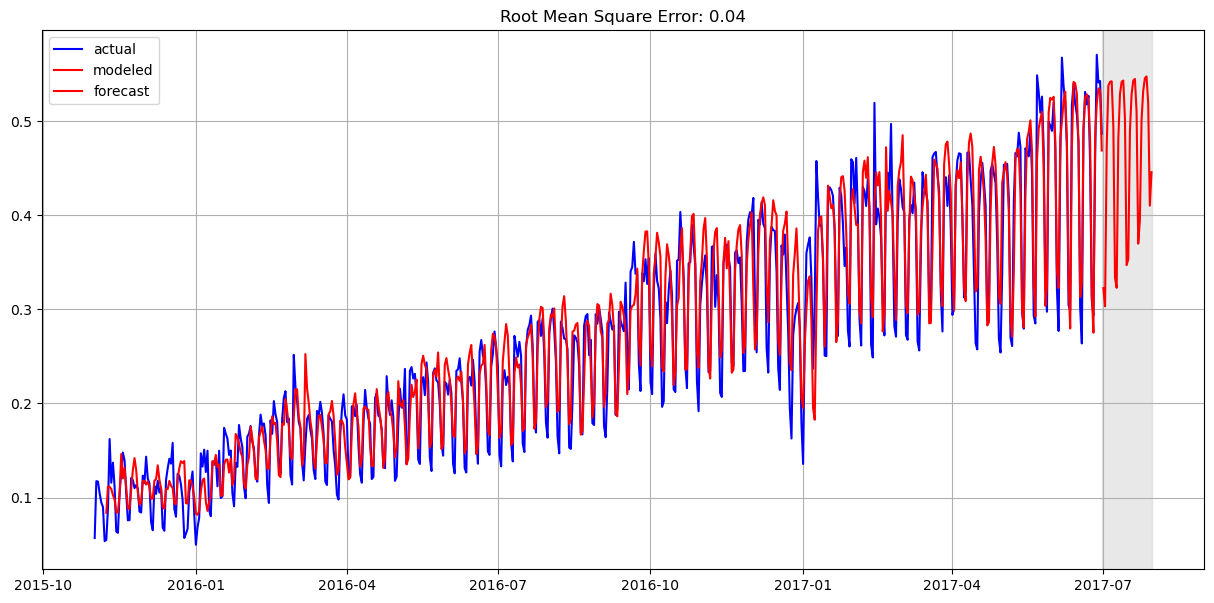

In [82]:
plot_results(daily_junc1, r_modeled, r_lstm_forecast)

In [83]:
r_lstm_forecast = n_step_forecast(daily_junc1_ts, r_model, lookback=7, n=30)
r_lstm_forecast

2017-07-01    [0.32254252]
2017-07-02     [0.3032346]
2017-07-03    [0.47314432]
2017-07-04     [0.5375742]
2017-07-05     [0.5416703]
2017-07-06     [0.5421946]
2017-07-07    [0.49415776]
2017-07-08     [0.3336116]
2017-07-09     [0.3228574]
2017-07-10     [0.4815326]
2017-07-11    [0.52879477]
2017-07-12     [0.5416899]
2017-07-13     [0.5429884]
2017-07-14    [0.50163865]
2017-07-15    [0.34700587]
2017-07-16     [0.3531129]
2017-07-17     [0.4899923]
2017-07-18     [0.5283158]
2017-07-19      [0.542861]
2017-07-20    [0.54472005]
2017-07-21     [0.5094851]
2017-07-22    [0.36977538]
2017-07-23    [0.39527872]
2017-07-24     [0.5013691]
2017-07-25     [0.5320678]
2017-07-26    [0.54544365]
2017-07-27     [0.5473316]
2017-07-28     [0.5187653]
2017-07-29    [0.41010952]
2017-07-30    [0.44567484]
Freq: D, Name: forecast, dtype: object

In [84]:
lstm_forecast = n_step_forecast(daily_junc1_ts, s_model, lookback=7, n=30)
lstm_forecast

2017-07-01     [0.3181777]
2017-07-02    [0.28490332]
2017-07-03     [0.3191625]
2017-07-04    [0.38136825]
2017-07-05    [0.41430405]
2017-07-06    [0.43468985]
2017-07-07     [0.3988642]
2017-07-08    [0.32491073]
2017-07-09     [0.2732243]
2017-07-10    [0.28816724]
2017-07-11    [0.34173414]
2017-07-12     [0.3865973]
2017-07-13    [0.38640252]
2017-07-14    [0.36513114]
2017-07-15    [0.33934268]
2017-07-16     [0.2708777]
2017-07-17     [0.2766683]
2017-07-18    [0.32854354]
2017-07-19    [0.37191337]
2017-07-20     [0.3667039]
2017-07-21    [0.35373554]
2017-07-22    [0.34231058]
2017-07-23    [0.27438274]
2017-07-24     [0.2725715]
2017-07-25     [0.3235118]
2017-07-26    [0.36201608]
2017-07-27    [0.35840154]
2017-07-28    [0.34930602]
2017-07-29    [0.33979756]
2017-07-30    [0.28062665]
Freq: D, Name: forecast, dtype: object

In [85]:
def prepare_results(model, preds, data, lookback):
    
    sample_plot = np.ones_like(data) * np.nan
    sample_plot[lookback:] = preds
    sample_df = pd.DataFrame(sample_plot, index=daily_junc1.index)
    return sample_df
r_modeled = prepare_results(r_model, r_preds, daily_junc1_ts, lookback=7)
r_modeled

,0
DateTime,
2015-11-01,NaN
2015-11-02,NaN
2015-11-03,NaN
2015-11-04,NaN
2015-11-05,NaN
...,...
2017-06-26,0.483033
2017-06-27,0.518542
2017-06-28,0.534617


In [86]:
s_modeled = prepare_results(s_model, s_preds, daily_junc1_ts, lookback=7)
s_modeled

,0
DateTime,
2015-11-01,NaN
2015-11-02,NaN
2015-11-03,NaN
2015-11-04,NaN
2015-11-05,NaN
...,...
2017-06-26,0.342084
2017-06-27,0.396280
2017-06-28,0.440702


In [87]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def root_mean_squared_error(y_true, y_pred): 
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [88]:
def plot_results(original, modeled, forecast): 
    """ Given 
        original: a time series with datetime index
        modeled: model fitted values
        forecast: inferenced values
        
        Plot the original time series and the prediction of the test set
    """

    # calculate RMSE values between the original and modeled
    error = root_mean_squared_error(original[train_len+lookback+1:],modeled[train_len+lookback+1:])

    # plot
    plt.figure(figsize=(15, 7))
    plt.title("Root Mean Square Error: {0:.2f}".format(error))
    plt.plot(original, c='b', label="actual")
    plt.plot(modeled, c='r', label="modeled")
    plt.plot(forecast, color='r', label="forecast")
    plt.axvspan(original.index[-1], forecast.index[-1], alpha=0.5, color='lightgrey')
    plt.legend()
    plt.grid(True);

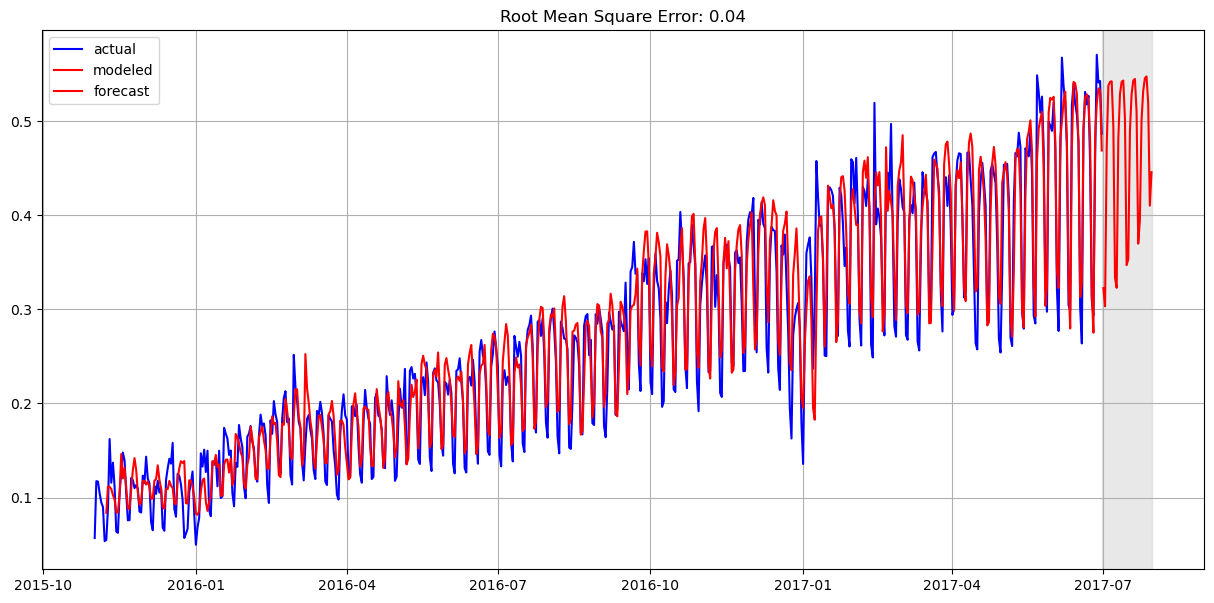

In [89]:
plot_results(daily_junc1, r_modeled, r_lstm_forecast)

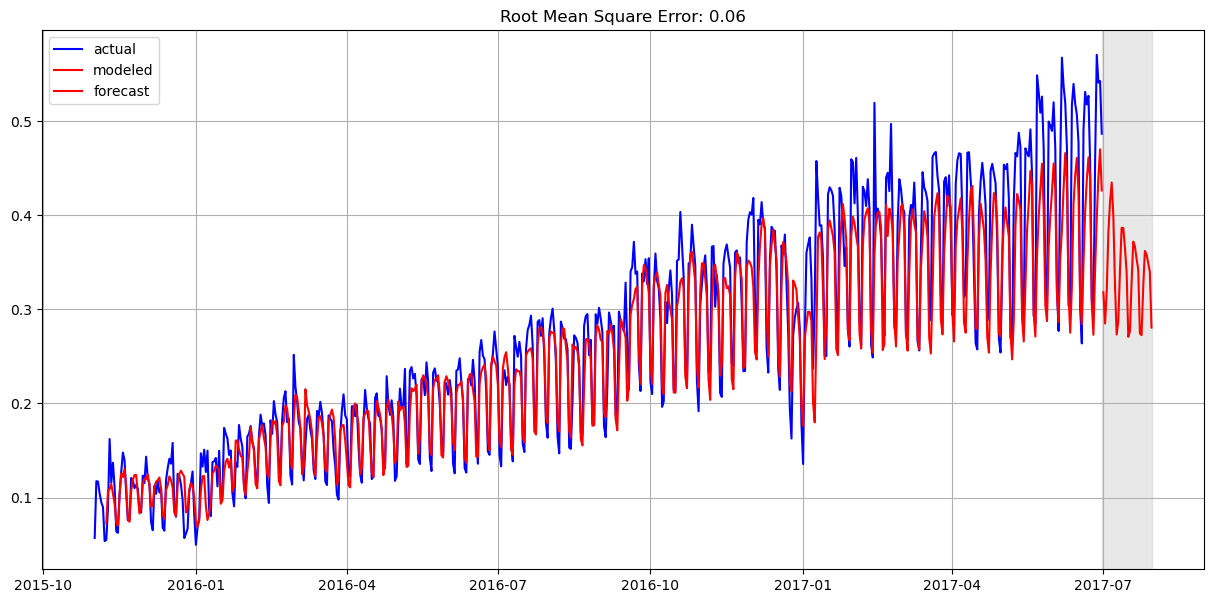

In [90]:
plot_results(daily_junc1, s_modeled, s_lstm_forecast)

### Model: ARIMA

In [91]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

In [92]:
ps = range(1, 3)
d=1 
qs = range(1, 3)
Ps = range(1, 3)
D=1 
Qs = range(1, 3)
s = 7 # season length 

# creating list with all the possible combinations of parameters
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

16

In [93]:
def optimizeARIMA(parameters_list, d):
    """
        Return dataframe with parameters and corresponding AIC
        
        parameters_list - list with (p, q) tuples
        d - integration order in ARIMA model
    """
    
    results = []
    best_aic = float("inf")

    for param in parameters_list:
        # we need try-except because on some combinations model fails to converge
        try:
            model = sm.tsa.statespace.SARIMAX(daily_junc1, order=(param[0], d, param[1])).fit(disp=-1)
        except:
            continue
        aic = model.aic
        # saving best model, AIC, and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])

    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    # sorting in ascending order, the lower AIC is - the better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table


In [94]:
%%time
result_table = optimizeARIMA(parameters_list, d)

CPU times: total: 11.3 s
Wall time: 12.2 s


In [95]:
result_table.head()

,parameters,aic
0,"(2, 2, 1, 1)",-2023.097861
1,"(2, 2, 1, 2)",-2023.097861
2,"(2, 2, 2, 1)",-2023.097861
3,"(2, 2, 2, 2)",-2023.097861
4,"(2, 1, 1, 1)",-1954.586361


In [96]:
p, q, P, Q = result_table.parameters[0]

best_model=sm.tsa.statespace.SARIMAX(daily_junc1, order=(p, d, q), 
                                        seasonal_order=(P, D, Q, s)).fit(disp=-1)
print(best_model.summary())

                                      SARIMAX Results                                      
Dep. Variable:                            Vehicles   No. Observations:                  608
Model:             SARIMAX(2, 1, 2)x(1, 1, [1], 7)   Log Likelihood                1415.469
Date:                             Fri, 03 Jan 2025   AIC                          -2816.938
Time:                                     23:39:24   BIC                          -2786.160
Sample:                                 11-01-2015   HQIC                         -2804.957
                                      - 06-30-2017                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0751      1.370     -0.055      0.956      -2.760       2.610
ar.L2          0.1819      

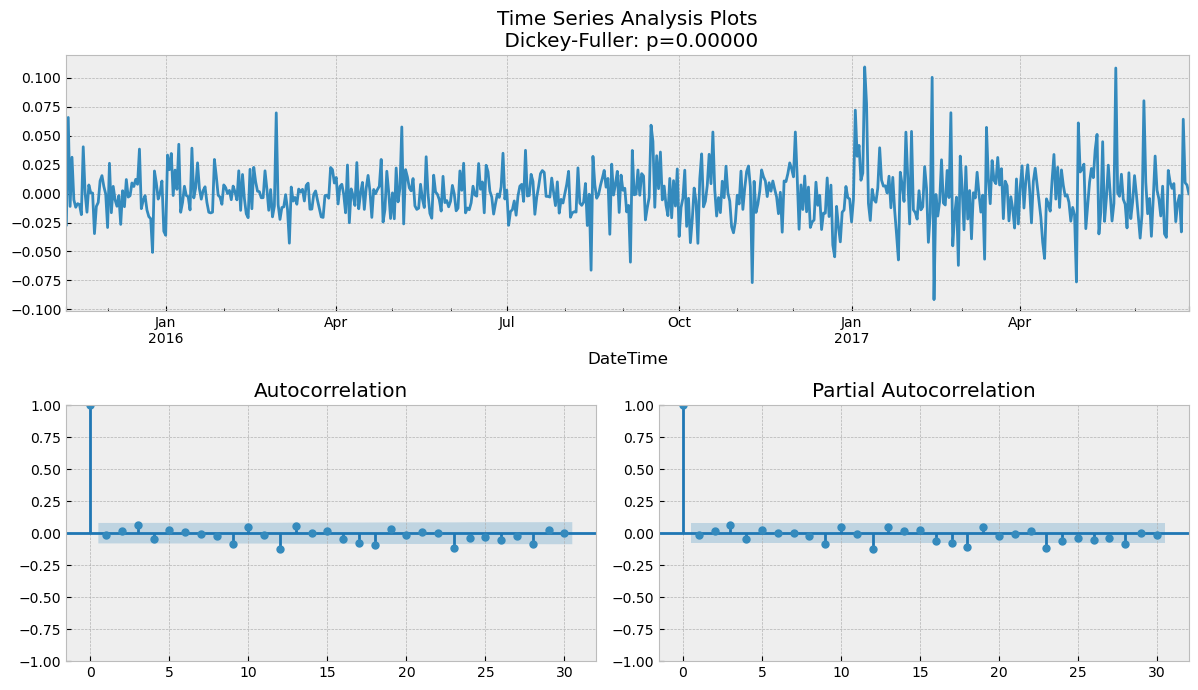

In [97]:
tsplot(best_model.resid[7+1:], lags=30)


In [98]:
def plotARIMA(series, model, n_steps, d):
    """
        Plots model vs predicted values
        
        series - dataset with timeseries
        model - fitted ARIMA model
        n_steps - number of steps to predict in the future
        d - integration order in the ARIMA model
    """
    # Adding model values
    data = series.copy()
    data['arima_model'] = model.fittedvalues
    # Making a shift of d steps due to differencing
    data['arima_model'][:d] = np.NaN
    
    # Forecasting n_steps forward 
    forecast = model.predict(start=data.shape[0], end=data.shape[0] + n_steps)
    forecast = pd.concat([data['arima_model'], forecast])

    # Calculate error, again shifting by d steps
    error = root_mean_squared_error(data[d:-1].values, data['arima_model'][d:].values)

    # Plotting
    plt.figure(figsize=(15, 7))
    plt.title("Root Mean Square Error: {0:.2f}".format(error))
    plt.plot(forecast, color='r', label="model")
    plt.axvspan(data.index[-2], forecast.index[-1], alpha=0.5, color='lightgrey')
    plt.plot(daily_junc1, label="actual")
    plt.legend()
    plt.grid(True)


In [99]:
arima_forecast = best_model.predict(start=daily_junc1.shape[0], end=daily_junc1.shape[0] + 30)
arima_forecast

2017-07-01    0.336925
2017-07-02    0.315257
2017-07-03    0.503056
2017-07-04    0.549911
2017-07-05    0.533260
2017-07-06    0.537550
2017-07-07    0.488431
2017-07-08    0.340938
2017-07-09    0.320516
2017-07-10    0.508050
2017-07-11    0.556537
2017-07-12    0.539645
2017-07-13    0.543909
2017-07-14    0.494645
2017-07-15    0.347112
2017-07-16    0.326664
2017-07-17    0.514204
2017-07-18    0.562656
2017-07-19    0.545770
2017-07-20    0.550034
2017-07-21    0.500773
2017-07-22    0.353241
2017-07-23    0.332794
2017-07-24    0.520334
2017-07-25    0.568787
2017-07-26    0.551900
2017-07-27    0.556165
2017-07-28    0.506904
2017-07-29    0.359372
2017-07-30    0.338925
2017-07-31    0.526464
Freq: D, Name: predicted_mean, dtype: float64

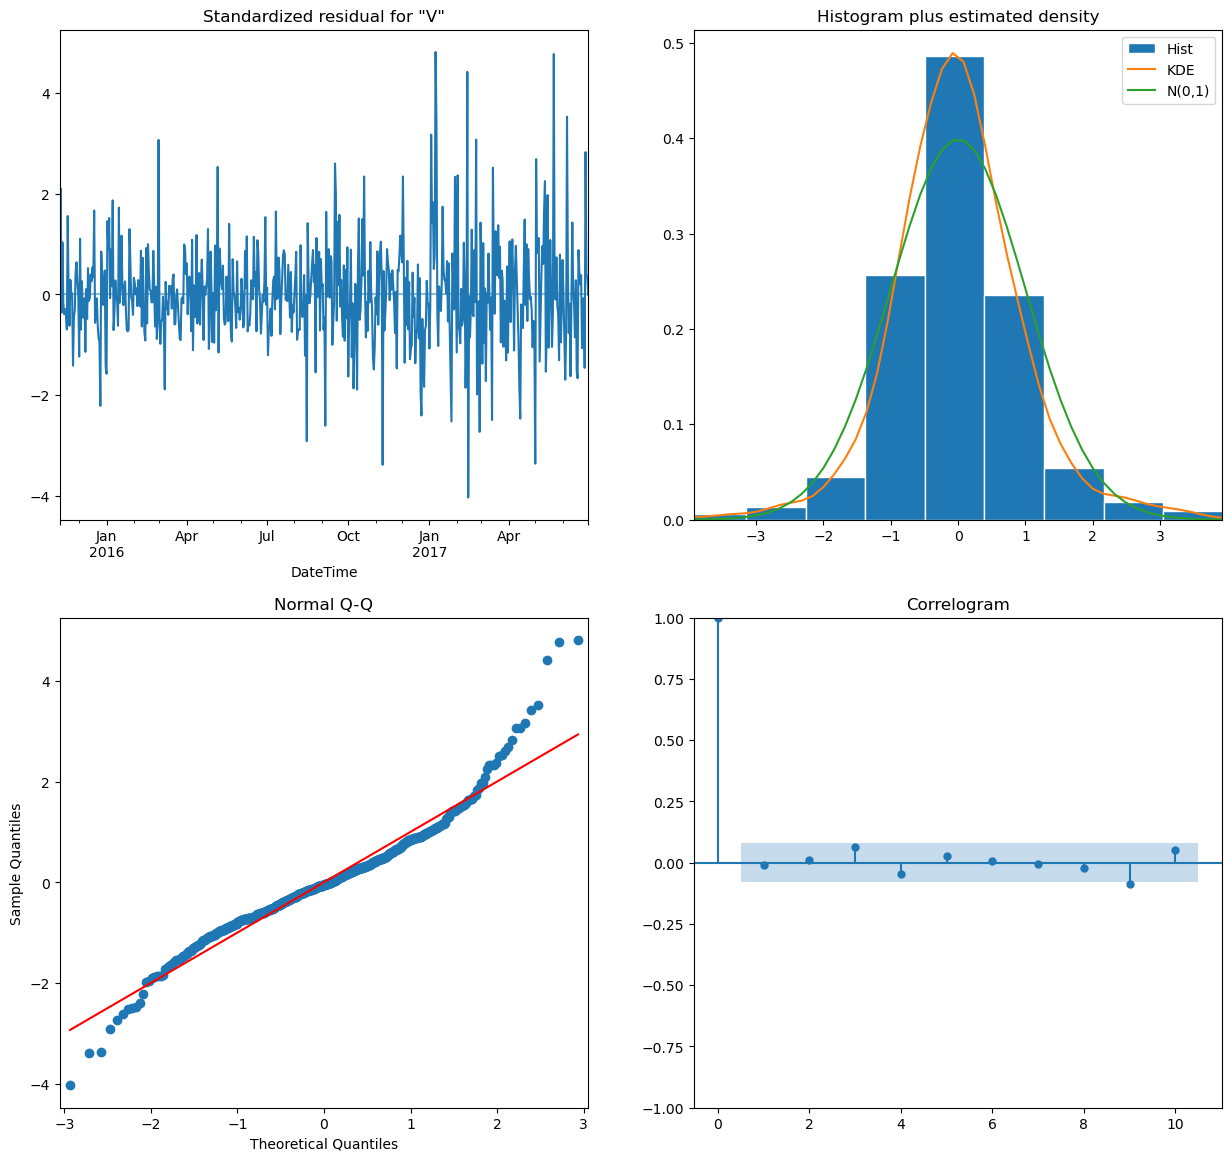

In [100]:
best_model.plot_diagnostics(figsize=(15, 14))
plt.show()